## Ocean Surface Mixed Layer Depths

This notebook plots the global distribution of surface mixed layer depths

In [1]:
import os

In [2]:
config_p125hist = {
    "startyr": "2000",
    "endyr": "2014",
    "dora_id": "odiv-255", #CM4x p125 historical
    "pathPP": None,
}

config_p125ssp585 = {
    "startyr": "2085",
    "endyr": "2099",
    "dora_id": "odiv-293", #CM4x p125 SSP585
    "pathPP": None,
}

config_p25hist = {
    "startyr": "2000",
    "endyr": "2014",
    "dora_id": "odiv-231", #CM4x p25 historical
    "pathPP": None,
}

config_p25ssp585 = {
    "startyr": "2085",
    "endyr": "2099",
    "dora_id": "odiv-232", #CM4x p25 SSP585
    "pathPP": None,
}

    
    
for config in [config_p125hist,config_p125ssp585,config_p25hist,config_p25ssp585]:
    for k, v in config.items():
        config[k] = (
            os.environ[f"MAR_{k.upper()}"]
            if f"MAR_{k.upper()}" in os.environ.keys()
            else v
    )

### Import Python Modules

In [3]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import copy 
import glob
import subprocess
import doralite
import momgrid as mg
import xesmf as xe

In [4]:
# momgrid will use a directory of pre-computed weights (do I need this?)
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

In [5]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0



# Define some local variables. These are taken from the doralite object
# or they can be defined locally
for config in [config_p125hist,config_p125ssp585,config_p25hist,config_p25ssp585]:
    experiment =  doralite.dora_metadata(config["dora_id"])
    expPP = experiment["pathPP"]
    expName = experiment["expName"]
    
    # Define start and end years
    start = int(config["startyr"])
    end = int(config["endyr"])
    
    auto_checkout = False
    
    print(expPP)

    component = "ocean_monthly"
    static = f"{component}/{component}.static.nc"
    varname = "*"
    
    chunk = "monthly_5yr"
    expfilelist = sorted(glob.glob(f"{expPP}{component}/av/{chunk}/{component}.*.nc", recursive=True))

    config['filelist'] = [x for x in expfilelist if is_in_range(x,start,end)]
    config['staticfile'] = f"{expPP}/{static}"
    #Storing for use later
    config['start'] = start
    config['end'] = end

    #Printing the files
    _ = [print(x) for x in config['filelist']]


/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.01.nc
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.02.nc
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.03.nc
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.04.nc
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.05.nc
/a

In [6]:
# # Determine what files are needed (leave this up to the developer for flexibility)
# # This is an example of what someone might do:

# component = "ocean_monthly"
# static = f"{component}/{component}.static.nc"
# varname = "*"

# chunk = "monthly_5yr"
# exp1filelist = sorted(glob.glob(f"{exp1PP}{component}/av/{chunk}/{component}.*.nc", recursive=True))
# exp2filelist = sorted(glob.glob(f"{exp2PP}{component}/av/{chunk}/{component}.*.nc", recursive=True))

# def is_in_range(file,start,end):
#     start = int(start)
#     end = int(end)
#     target = set(list(range(start,end+1)))
#     fname = os.path.basename(file)
#     times = fname.split(".")[1]
#     times = times.split("-")
#     times = [int(x[0:4]) for x in times]
#     candidate = set(list(range(times[0],times[1]+1)))
#     return len(candidate.intersection(target)) > 0

# exp1filelist = [x for x in exp1filelist if is_in_range(x,start,end)]
# exp1staticfile = f"{exp1PP}/{static}"
# exp2filelist = [x for x in exp2filelist if is_in_range(x,start,end)]
# exp2staticfile = f"{exp2PP}/{static}"

# _ = [print(x) for x in exp1filelist]
# _ = [print(x) for x in exp2filelist]

In [7]:
if not "DORA_EXECUTE" in os.environ.keys():
    subprocess.run(["dmwho"])

MINUTES  USERNAME                  HOST    COMMAND FILES
    0.8  Hiroyuki.Murakami         an101   dmget       1


In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    for config in [config_p125hist,config_p125ssp585,config_p25hist,config_p25ssp585]:
        filelist=config['filelist']
        staticfile=config['staticfile']
                                    
        cmd = ["dmget"]+filelist+[staticfile]
        if auto_checkout:
            print("Calling dmget on files ...")
            _ = subprocess.check_output(cmd)
        else:
            print("Paste to terminal to dmget files ...")
            out_string=''
            for cell in cmd:
                out_string+=' '+cell
            print(out_string)

Paste to terminal to dmget files ...
 dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.01.nc /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.02.nc /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.03.nc /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.04.nc /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2000-2004.05.nc /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_O

In [9]:
for config in [config_p125hist,config_p125ssp585,config_p25hist,config_p25ssp585]:
    filelist = config['filelist']
    start = config['start']
    end = config['end']
    config['ds'] = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
    config['ds'] = config['ds'].regrid(resolution=1)
    config['ds'] = config['ds'].sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))[['MLD_EN1','MLD_EN2']]
    config['ds'] = config['ds'].groupby('time.month').mean('time')

/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/momgrid/classes.py:750: UserWarning: Unsupported grid type: 
  warnings.warn(str(exc))
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/momgrid/external.py:111: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/momgrid/classes.py:750: UserWarning: Unsupported grid type: 
  warnings.warn(str(exc))
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/momgrid/external.py:111: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/momgrid/classes.py:750: UserWarning: Unsupported grid type: 
  warnings.warn(str(exc))
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/momgrid/external.py:111: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/net2/bgr/mamba/miniforge3/envs/om5/lib/python

In [10]:
#Obs File
obs_en1 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_25.nc'
obs_en2 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_2500.nc'
ds_en1= xr.open_dataset(obs_en1)
ds_en2= xr.open_dataset(obs_en2)
ds_obsdata = xr.Dataset()
ds_obsdata['lat']=ds_en1['Lat'].values
ds_obsdata['lon']=ds_en1['Lon'].values
ds_obsdata['Month']=ds_en1['Month'].values
ds_obsdata['MLD_EN1']=(('Month','lon','lat'),ds_en1['MLD_mean'].values)
ds_obsdata['MLD_EN2']=(('Month','lon','lat'),ds_en2['MLD_mean'].values)

In [11]:
def Set_Plot_ds(cmn_lat,cmn_lon):
    ds_plot = xr.Dataset()
    ds_plot['lat'] = cmn_lat
    ds_plot['lon'] = cmn_lon
    return ds_plot

for config in [config_p125hist,config_p125ssp585,config_p25hist,config_p25ssp585]:
    ds = config['ds']
    cmn_lat = np.copy(ds['lat'])
    cmn_lon = np.copy(ds['lon'])
    cmn_lon[cmn_lon<-240]+=360
    cmn_lon[cmn_lon>120]-=360
    xi = np.argsort(cmn_lon)
    cmn_lon = cmn_lon[xi]
    config['ds_min'] = Set_Plot_ds(cmn_lat,cmn_lon)
    config['ds_max'] = Set_Plot_ds(cmn_lat,cmn_lon)
    
    
    config['ds_min']['model'] = (('lat','lon'),ds.MLD_EN1.min(dim='month').values[:,xi])
    config['ds_max']['model'] = (('lat','lon'),ds.MLD_EN2.max(dim='month').values[:,xi])
    
    regridder = xe.Regridder(ds_obsdata, config['ds_min'], "conservative_normed",periodic=True,unmapped_to_nan=True)
    config['ds_min']['obs'] = (('lat','lon'),regridder(ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).data.T))
    config['ds_max']['obs'] = (('lat','lon'),regridder(ds_obsdata.MLD_EN2.max(dim='Month',skipna=False).data.T))
    #The regridder is extrapolating with zero's instead of NaN and I don't know why.
    # ds_min['obs'][ds_min.lat>ds_obsdata.lat.max()]=np.NaN
    # ds_min['obs'][ds_min.lat<ds_obsdata.lat.min()]=np.NaN
    # ds_max['obs'][ds_max.lat>ds_obsdata.lat.max()]=np.NaN
    # ds_max['obs'][ds_max.lat<ds_obsdata.lat.min()]=np.NaN

/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages

In [12]:
Dims = [-240,120,-90,90]
Central = 0.5*(Dims[0]+Dims[1])
CLim1_min=[10,60]
CLim2_min=[-20,20]
CLim1_max=[10,800]
CLim2_max=[-200,200]

        
Options = {
    'Dims':Dims,
    'central':Central,
    'CLim1_min':CLim1_min,
    'CLim2_min':CLim2_min,
    'CLim1_max':CLim1_max,
    'CLim2_max':CLim2_max,
}

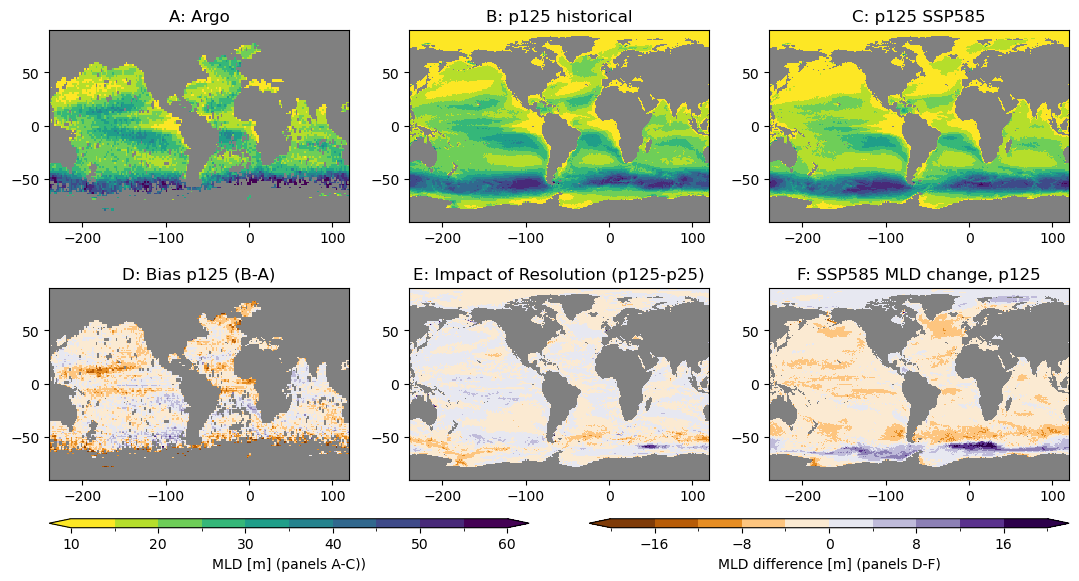

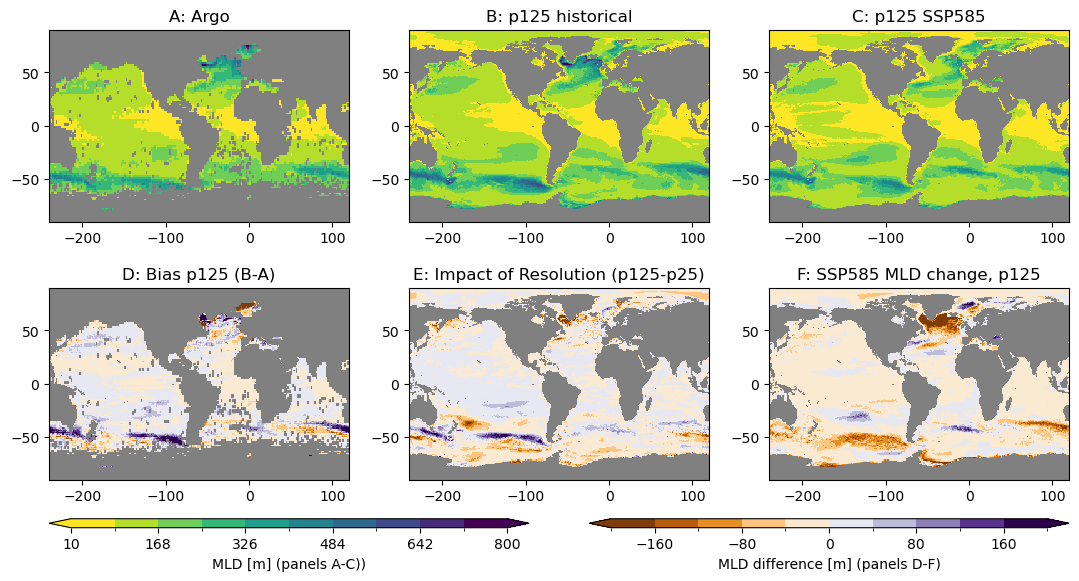

In [13]:
for method in ['min','max']:
    ds_var='ds_'+method
    cmap = copy.copy(plt.cm.viridis_r)
    cmap2 = copy.copy(plt.cm.PuOr)
    cmap.set_bad('gray')
    cmap2.set_bad('gray')
    levels = np.linspace(Options['CLim1_'+method][0],Options['CLim1_'+method][1],11);
    levels2 = np.linspace(Options['CLim2_'+method][0],Options['CLim2_'+method][1],11);
        
    F = plt.figure(figsize=(12, 6))
    
    lon = config_p125hist[ds_var]['lon'].values
    lat = config_p125hist[ds_var]['lat'].values
    p125hist = config_p125hist[ds_var]['model'].values
    p25hist = config_p25hist[ds_var]['model'].values
    p125ssp585 = config_p125ssp585[ds_var]['model'].values
    p25ssp585 = config_p25ssp585[ds_var]['model'].values
    
    obs = config_p25hist[ds_var]['obs'].values
    p125bias = p125hist-obs
    p25bias = p25hist-obs
    p125p25diff = p125hist-p25hist
    climatechange_p25 = p25ssp585-p25hist
    climatechange_p125 = p125ssp585-p125hist
    lon,lat = np.meshgrid(lon,lat)
                           
    ax=F.add_axes([0.1,0.55,0.25,0.32])
    cb1 = ax.pcolormesh(lon,lat,obs,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('A: Argo')
    
    ax=F.add_axes([0.4,0.55,0.25,0.32])
    cb1 = ax.pcolormesh(lon,
                        lat,
                        p125hist,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('B: p125 historical')
        
    
    ax=F.add_axes([0.7,0.55,0.25,0.32])
    cb1 = ax.pcolormesh(lon,
                        lat,
                        p125ssp585,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('C: p125 SSP585')
    
    
    ax=F.add_axes([0.1,0.12,0.25,0.32])
    cb2 = ax.pcolormesh(lon,lat,p125bias,
                       shading="auto", 
                       cmap=cmap2,
                       norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False),)
    ax.set_title('D: Bias p125 (B-A)')
    
    ax=F.add_axes([0.4,0.12,0.25,0.32])
    cb2 = ax.pcolormesh(lon,
                        lat,
                        p125p25diff,
                       shading="auto", 
                       cmap=cmap2,
                       norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False),)
    ax.set_title('E: Impact of Resolution (p125-p25)')
        
    ax=F.add_axes([0.7,0.12,0.25,0.32])
    cb2 = ax.pcolormesh(lon,lat,climatechange_p125,
                       shading="auto", 
                       cmap=cmap2,
                       norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False),)
    ax.set_title('F: SSP585 MLD change, p125')
    
    
    
    cax1 = F.add_axes([0.1, 0.04, 0.4, 0.015])
    cbar1 = plt.colorbar(cb1,cax=cax1,orientation='horizontal',extend='both')
    cbar1.set_label('MLD [m] (panels A-C))')
    cax2 = F.add_axes([0.55, 0.04, 0.4, 0.015])
    cbar2 = plt.colorbar(cb2,cax=cax2,orientation='horizontal',extend='both')
    cbar2.set_label('MLD difference [m] (panels D-F)')
    #F.suptitle('Ocean Surface Mixed Layer Depths: '+method+'imum of monthly climatology')
    F.savefig('MLD_CM4x_'+method+'.png',dpi=400,bbox_inches='tight')